<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-stuff" data-toc-modified-id="Random-stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random stuff</a></span></li><li><span><a href="#Workflow" data-toc-modified-id="Workflow-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Workflow</a></span><ul class="toc-item"><li><span><a href="#Reading-layers" data-toc-modified-id="Reading-layers-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reading layers</a></span></li><li><span><a href="#EASE-Grid" data-toc-modified-id="EASE-Grid-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EASE Grid</a></span></li><li><span><a href="#Tabular-to-Spatial" data-toc-modified-id="Tabular-to-Spatial-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Tabular to Spatial</a></span></li><li><span><a href="#Node-class" data-toc-modified-id="Node-class-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Node class</a></span></li><li><span><a href="#Layer-class" data-toc-modified-id="Layer-class-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Layer class</a></span></li></ul></li><li><span><a href="#Get-application-layer-&amp;-data" data-toc-modified-id="Get-application-layer-&amp;-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get application layer &amp; data</a></span></li><li><span><a href="#New-functionality" data-toc-modified-id="New-functionality-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>New functionality</a></span><ul class="toc-item"><li><span><a href="#Grid-style" data-toc-modified-id="Grid-style-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Grid style</a></span></li><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#Folium-map" data-toc-modified-id="Folium-map-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Folium map</a></span></li></ul></li><li><span><a href="#Application" data-toc-modified-id="Application-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Application</a></span></li></ul></div>

*note: TOC above will not work in GitHub notebook viewer*

# Aggregate of ORNL DAAC Soil Moisture Visualizer outputs

Import modules and authenticate with URS:

In [1]:
# import modules
import os
import json
import warnings
from io import StringIO
from datetime import datetime

import branca
import folium
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from shapely.geometry import shape
from folium.plugins import MiniMap

# suppress scientific notation output
np.set_printoptions(suppress=True)

# for saving/loading example xr.Dataset
try:                             # <- Python 3
    import _pickle as pickle
except ModuleNotFoundError:      # <- Python 2
    import pickle

# force Earthdata login
from ursjupyter import *

'Login successful. Download with: session.get(url)'

## Random stuff

In [2]:
smvdownload = "https://airmoss.ornl.gov/cgi-bin/viz/api/download.pl?"
smvdatasets = pd.read_csv("docs/smvdatasets.csv",index_col="dataset",header=0)

numvalid = lambda v: np.count_nonzero(~np.isnan(v.data))
allnan = lambda v: numvalid(v)==0

node_header = ["id", "lat", "lon", "node"]
disabled_sources =  ["FLUXNET", "MODIS", "GRACE", "PBOH2O"]
layer_header = ["id", "lat", "lon", "layer", "nodes", "points", "xr"]

## Workflow
### Reading layers

In [3]:
def get_colors(n, cmap=cm.Set2):
    """ 
    Takes integer count of colors to map and optional kwarg: 
      'cmap=matplotlib.cm.<cmap>'.
    """

    cspace = np.linspace(0.0, 1.0, n)           # *1
    rgb = cmap(cspace)                          # *2
    cols = [colors.to_hex(c[0:3]) for c in rgb] # *3

    return(cols)

def from_geojson(input_geojson):
    """ """
    
    with open(input_geojson, "r") as f:
        shapes = json.load(f)
    features = shapes["features"]
    
    return(features)

Read the geojson file and print the first feature's properties:

In [4]:
shapes = "docs/nrcs_sites/barTbar_pastures_wint_wgs84.json"
features = from_geojson(shapes)

features[0]["properties"]

{'OBJECTID': 1,
 'FEATID': 0,
 'Shape_Leng': 5.26074369606,
 'Shape_Area': 0.11906594189}

Plot geojson:

In [5]:
import folium
from IPython.display import display
from ipywidgets import Layout, HBox, VBox, HTML

b = ('https://server.arcgisonline.com/ArcGIS/rest/'
     'services/World_Imagery/MapServer/tile/{z}/{y}/{x}')
c = [shape(features[0]["geometry"]).centroid.y,
     shape(features[0]["geometry"]).centroid.x]

m = folium.Map(
    tiles=b,
    location=c,
    zoom_start=9,
    control_scale=True,
    prefer_canvas=True,  
    attr='Basemap by ESRI')

cols = get_colors(len(features))
sfunc = lambda feature: {'fillColor':'blue','color':'white','weight': 0.75}
hfunc = lambda feature: {'fillColor':'white','color':'black','weight': 1.5}
styles = {
    'style_function': sfunc,
    'highlight_function': hfunc}

folium.GeoJson(features[0], **styles).add_to(m)

m

### EASE Grid

In [6]:
latf = "docs/EASE2_M09km.lats.3856x1624x1.double"
lonf = "docs/EASE2_M09km.lons.3856x1624x1.double"

lats = np.fromfile(latf, dtype=np.float64).flatten() 
lons = np.fromfile(lonf, dtype=np.float64).flatten()

crds = np.dstack((lats,lons))[0]
crds.shape

(6262144, 2)

Get ease grid points:

In [7]:
def get_contains(geom, pt):
    """ """
    spt = shape({"type": "Point", "coordinates":(pt[1], pt[0])})
    sptin = True if geom.contains(spt) else False
    return(sptin)
        

def get_ease(shapely_geom):
    """ """
    bnds = shapely_geom.bounds 
    
    ease = crds[
        (bnds[1]<lats) & (lats<bnds[3]) &     # ybnds < lat < ybnds
        (bnds[0]<lons) & (lons<bnds[2])]      # xbnds < lon < xbnds
    
    ease_table = pd.DataFrame({
        "id": list(range(len(ease))), 
        "lat": [p[0] for p in ease], 
        "lon": [p[1] for p in ease], 
        "tup": [(p[0], p[1]) for p in ease], 
        "in": [get_contains(shapely_geom, p) for p in ease]})

    return(ease_table)


shply = shape(features[0]["geometry"])
ease = get_ease(shply)

ease.head(10)

,id,lat,lon,tup,in
0,0,35.034151,-111.332988,"(35.03415148890063, -111.33298755186719)",False
1,1,35.034151,-111.239627,"(35.03415148890063, -111.2396265560166)",False
2,2,35.034151,-111.146266,"(35.03415148890063, -111.14626556016597)",False
3,3,35.034151,-111.052905,"(35.03415148890063, -111.05290456431534)",True
4,4,35.034151,-110.959544,"(35.03415148890063, -110.95954356846472)",True
5,5,35.034151,-110.866183,"(35.03415148890063, -110.86618257261411)",False
6,6,34.948340,-111.332988,"(34.948339866100525, -111.33298755186719)",False
7,7,34.948340,-111.239627,"(34.948339866100525, -111.2396265560166)",False
8,8,34.948340,-111.146266,"(34.948339866100525, -111.14626556016597)",False
9,9,34.948340,-111.052905,"(34.948339866100525, -111.05290456431534)",True


Map some points:

In [8]:
def get_marker(i, lat, lon):
    """ """
    
    poptext = """<p>
    <strong>Node:</strong> {i}<br>
    <strong>Latitude:</strong> {lat}<br>
    <strong>Longitude:</strong> {lon}
    </p>""".format(i=i, lat=round(lat, 3), lon=round(lon, 3))
    
    pop = folium.Popup(
        folium.Html(poptext, script=True), 
        max_width=150, 
        min_width=150)

    args = {"radius": 7, 
            "weight": 1, 
            "popup": pop, 
            "color": "white", 
            "fill": True, 
            "fill_color": "gray"}
    
    marker = folium.CircleMarker(location=[lat, lon], **args)
    
    return(marker)


ease["mark"] = [None]*len(ease.index)
for ix, row in ease.iterrows():
    ease.at[ix, "mark"] = get_marker(ix, row["lat"], row["lon"])
    ease.iloc[ix]["mark"].add_to(m)

m

### Tabular to Spatial

In [9]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                      # get file from string

    df = pd.read_csv(
        f, 
        header=4, 
        index_col="time",
        error_bad_lines=False, 
        warn_bad_lines=False)                        # read to df
    df.index = pd.to_datetime(df.index)              # convert index to dates
    
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)           # split col by ;
    df = df.replace('', np.nan)                       # set '' to nan
    df = df.astype(float)                             # set all to float
    df.columns = ["Min","Mean","Max"]                 # add column names
    
    return(df)


def pd_to_xr(dataset, df):
    """Makes an xr.Dataset from a pandas column (series) and coords."""

    a = smvdatasets.loc[dataset].to_dict()
    x = xr.DataArray(df, name=dataset, attrs=a)
    x = x.rename(dict(dim_1="stat"))
    
    return(x)


def get_coords(node):
    """ """

    n = xr.DataArray(data=[node.id], dims=["node"])
    
    y = xr.DataArray(data=[node.lat], coords=[n], dims=["node"], attrs=dict(
        standard_name="latitude",
        long_name="latitude coordinate",
        units="degrees_north"))
    
    x = xr.DataArray(data=[node.lon], coords=[n], dims=["node"], attrs=dict(
        standard_name="latitude",
        long_name="latitude",
        units="degrees_north"))
    
    return(y, x)


def get_node_xr(node, grid=True):
    """ """
        
    node.submit(session) # download the data
    df = node.df                                         # get the sample df
    
    ds = {}
    for dataset in df.columns:
        a = smvdatasets.loc[dataset].to_dict()
        if a["source"] not in disabled_sources:
            split_column = split_pd(df[dataset])
            ds[dataset] = pd_to_xr(dataset, split_column)
    
    node.grid = grid
    y, x = get_coords(node)
    xds = xr.merge(ds.values())                          # merge to one xr
    xds = xds.assign_coords(lat=y, lon=x)                # add coord arrays
        
    return(xds)

### Node class

In [10]:
class Node(object):
    """ """

    off = {"fill_opacity": 0.4, "stroke": False}
    
    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        
        self.id = i
        self.lat = lat 
        self.lon = lon
        self.on = False
        self.dl = smvdownload+"lt={0}&ln={1}&d=smap".format(lat, lon)
        
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)

    def submit(self, session):
        """Called by parent. Downloads url. Updates status."""

        self.response = session.get(self.dl)
        self.df = txt_to_pd(self.response.text)            # read to
        self.on = True                                     # toggle status on

### Layer class

In [11]:
def get_layer_data(i, feat, col="#FFFFFF", opac=0.4, samp=True):
    """ """

    shapely_geom = shape(feat["geometry"])              # shapely geom
    nodes = get_ease(shapely_geom) if samp else None    # ease grid points
    nodes["node"] = [Node(i,r["lat"],r["lon"]) for i,r in nodes.iterrows()]
    nodes["xr"] = [None]*len(nodes.index)               # make empty col
    
    cent = shapely_geom.centroid                        # centroid
    lat, lon = cent.y, cent.x                           # lat, lon
    feat["properties"].update({"id": i, "style": {
        "weight": 0.75, 
        "color": "aliceblue",
        "fillColor": col,
        "fillOpacity": opac}})

    return((feat, lat, lon, nodes))


class Layer(object):
    """ """

    def __init__(self, i, feat, col=None, grid=True):
        """ """
        
        layer_data = get_layer_data(i, feat, col)
        
        self.id = i
        self.feat = layer_data[0]
        self.lat = layer_data[1]
        self.lon = layer_data[2]
        self.nodes = layer_data[3]
        self.grid = grid
        
        self.dl = False    # downloaded or nah?
        self.on = False    # toggle on or nah?

    def submit(self, session):
        """ """
        
        for i, node in self.nodes.iterrows():         # loop over sample pts
            if not node["node"].on:              
                self.nodes.at[i,"xr"] = get_node_xr(
                    node["node"], grid=self.grid)     # get xr dataset
        self.xr = xr.concat(self.nodes["xr"].tolist(), "node")
    
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.layer, arg, val)
    
    def toxy(self):
        """ """    
        
        self.xr = self.xr.set_index({"node": ["lat", "lon"]})
        self.xr = self.xr.unstack()

## Get application layer & data

Running this cell will either:
* open the previously saved example dataset at `docs/feat1.pkl`, or
* request the data for feature1 if no pickled dataset exist in repo directory
```python
try:
    with open('docs/feat1.pkl', 'rb') as output:
        poly = pickle.load(output)               # try to load binary file
except:
    poly = Layer(1, features[0])                 # get Layer class       
    poly.submit(session)                         # request all nodes
    with open('docs/feat1.pkl', 'wb') as output:
        pickle.dump(poly, output, -1)            # dump to binary file
```

In [12]:
poly = Layer(1, features[0])     # get Layer class       
poly.submit(session)             # request all nodes

poly.xr

<xarray.Dataset>
Dimensions:                     (node: 36, stat: 3, time: 6223)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-04-14
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * node                        (node) int64 0 1 2 3 4 5 6 ... 30 31 32 33 34 35
    lat                         (node) float64 35.03 35.03 35.03 ... 34.61 34.61
    lon                         (node) float64 -111.3 -111.2 ... -111.0 -110.9
Data variables:
    SoilSCAPE_surface           (node, time, stat) float64 nan nan ... nan nan
    SoilSCAPE_rootzone          (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_surface        (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_rootzone       (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L4_rootzone         (node, time, stat) float64 nan nan ... nan nan
    SMAP_surface                (node, time, stat) float64 nan nan ... 17.45
    SMAP_rootzone               

## New functionality
Plot time series mean:

C:\Applications\Python\anaconda3_2\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Applications\Python\anaconda3_2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


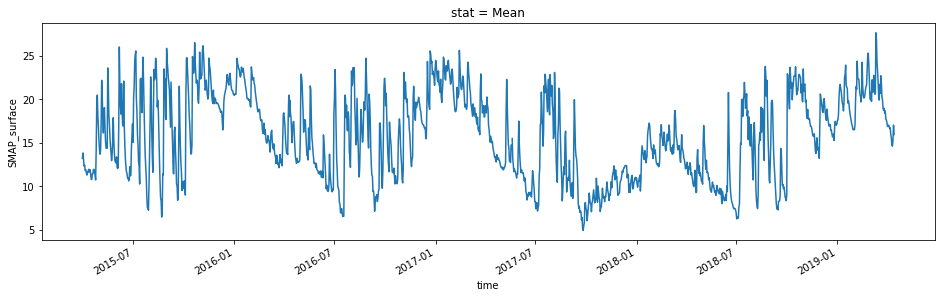

In [13]:
poly.xr["SMAP_surface"].sel(stat="Mean").mean("node").plot(x="time", figsize=(16, 4))

### Grid style
**The new Layer class method `Layer.toxy` converts the "node style" xarray object that we created for the USFS workshop to a "grid style":**

In [14]:
poly.toxy(); poly.xr

<xarray.Dataset>
Dimensions:                     (lat: 6, lon: 6, stat: 3, time: 6223)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-04-14
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * lat                         (lat) float64 34.61 34.69 34.78 ... 34.95 35.03
  * lon                         (lon) float64 -111.3 -111.2 ... -111.0 -110.9
Data variables:
    SoilSCAPE_surface           (time, stat, lat, lon) float64 nan nan ... nan
    SoilSCAPE_rootzone          (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L2_3_surface        (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L2_3_rootzone       (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L4_rootzone         (time, stat, lat, lon) float64 nan nan ... nan
    SMAP_surface                (time, stat, lat, lon) float64 nan nan ... 9.59
    SMAP_rootzone               (time, stat, lat, lon) float64 nan nan ... 17.45
    NEE_mean             

Now the same plotting function used above renders a gridded plot instead of a time series:

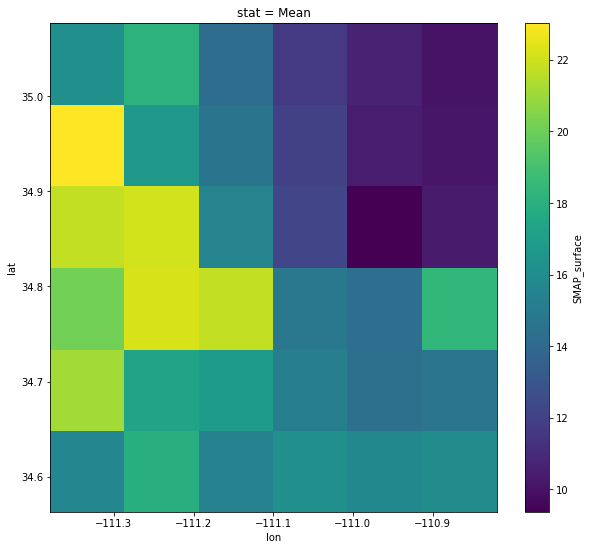

In [15]:
poly.xr["SMAP_surface"].sel(stat="Mean").mean("time").plot(figsize=(10,9))

### Linear regression

Borrowed from:
https://gist.github.com/luke-gregor/4bb5c483b2d111e52413b260311fbe43

This could be simplified.

In [16]:
from scipy import stats

def xarray_trend(xarr): 
    
    # getting shapes
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # LINEAR REGRESSION
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # preparing outputs
    out = xarr[:2].mean('time')
    
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return(xarr_out)

Get most recent timestep and calculate linear trend over two weeks:

In [17]:
twowk = poly.xr["SMAP_surface"].sel(stat="Mean").isel(time=slice(-15,-1))

# last available timestep
last = twowk[-1].data

# two week trend via linear regression
twowkt = xarray_trend(twowk)
twowktd = twowkt["slope"].data    # slope
twowkpd = twowkt["pval"].data     # p value

twowktd

array([[-0.33281319, -0.27795604, -0.25474725, -0.21156044, -0.19382418,
        -0.19243956],
       [-0.24804396, -0.3176044 , -0.2523956 , -0.25591209, -0.23175824,
        -0.21672527],
       [-0.25468132, -0.26916484, -0.22637363, -0.23151648, -0.19595604,
        -0.12696703],
       [-0.23813187, -0.22637363, -0.21505495, -0.14993407, -0.0807033 ,
        -0.02641758],
       [-0.1847033 , -0.20263736, -0.13415385, -0.0476044 ,  0.03134066,
         0.0516044 ],
       [-0.17008791, -0.11740659, -0.07793407,  0.004     ,  0.04821978,
         0.07753846]])

In [19]:
# make a colormap for soil moisture
cmap = branca.colormap.linear.RdBu_03.scale(last.min(), last.max())
cmap.caption = 'volumetric soil moisture (%; SMAP; 0-5cm depth)'

# make a colormap for trend
cmapt = branca.colormap.linear.RdBu_03.scale(twowktd.min(), twowktd.max())
cmapt.caption = 'trend via linear regression'

# make a colormap for pval
cmapp = branca.colormap.linear.RdBu_03.scale(twowkpd.min(), twowkpd.max())
cmapp.caption = 'p-value of linear regression'

# make a minimap
minimap = MiniMap(toggle_display=True)

### Folium map

This grid is the mean through all tim

In [20]:
def get_bounds(poly):
    """ """
    lat, lon = poly.xr.lat.data, poly.xr.lon.data
    hlat, hlon = abs(lat[1]-lat[0]), abs(lon[1]-lon[0])  
    return([[lat.min()-hlat, lon.min()-hlon], 
            [lat.max()+hlat, lon.max()+hlon]])


def plot_raster(im, nm, bd, cp, show=False):
    """ """
    folium.raster_layers.ImageOverlay(
        image=im,
        name=nm,
        bounds=bd,
        show=show,
        opacity=0.75,
        pixelated=True,
        mercator_project=True,
        colormap=lambda x: cp.rgb_bytes_tuple(x)).add_to(m)

# reset the map
m = folium.Map(
    tiles=b,
    attr="ESRI",
    location=c,
    zoom_start=9,
    control_scale=True,
    prefer_canvas=True)

# add the layer
sfunc = lambda f: {'color':'white','weight': 1, 'fillOpacity': 0}
folium.GeoJson(features[0], control=False, style_function=sfunc).add_to(m)

# add colormap and minimap
m.add_child(minimap)
m.add_child(cmap)
#m.add_child(cmapt)
#m.add_child(cmapp)

# make a list of bounds; must shift half x and y
bnds = get_bounds(poly)

# plot the trend and p-value
margs = dict(im=last, nm="soil moisture", bd=bnds, cp=cmap)
plot_raster(**margs)
targs = dict(im=twowktd, nm="linear trend", bd=bnds, cp=cmapt, show=True)
plot_raster(**targs)
pargs = dict(im=twowkpd, nm="p-value (0.05)", bd=bnds, cp=cmapp)
plot_raster(**pargs)

# layer controls
folium.LayerControl().add_to(m)

m

## Application

Core functions and classes are copied from above so I don't break them.

In [21]:
# Updating color style


basemap = ('https://server.arcgisonline.com/ArcGIS/rest/'
           'services/World_Imagery/MapServer/tile/{z}/{y}/{x}')


class Node(object):
    """ """

    off = {"fill_opacity": 0.4, "stroke": False}
    
    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        
        self.id = i
        self.lat = lat 
        self.lon = lon
        self.on = False
        self.dl = smvdownload+"lt={0}&ln={1}&d=smap".format(lat, lon)
        
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)

    def submit(self, session):
        """Called by parent. Downloads url. Updates status."""

        self.response = session.get(self.dl)
        self.df = txt_to_pd(self.response.text)            # read to
        self.on = True                                     # toggle status on


def get_layer_data(i, feat, col="#FFFFFF", opac=0.4, samp=True):
    """ """

    shapely_geom = shape(feat["geometry"])              # shapely geom
    nodes = get_ease(shapely_geom) if samp else None    # ease grid points
    nodes["node"] = [Node(i,r["lat"],r["lon"]) for i,r in nodes.iterrows()]
    nodes["xr"] = [None]*len(nodes.index)
    
    cent = shapely_geom.centroid                        # centroid
    lat, lon = cent.y, cent.x                           # lat, lon
    feat["properties"].update({"id": i, "style": {
        "weight": 0.75, 
        "color": "aliceblue",
        "fillColor": col,
        "fillOpacity": opac}})

    return((feat, lat, lon, nodes))


class Layer(object):
    """ """

    def __init__(self, i, feat, col=None, grid=True):
        """ """
        
        layer_data = get_layer_data(i, feat, col)
        
        self.id = i
        self.grid = grid
        self.feat, self.lat, self.lon, self.nodes = layer_data
        
        self.dl = False    # downloaded or nah?
        self.on = False    # toggle on or nah?

    def submit(self, session):
        """ """
        
        for i, node in self.nodes.iterrows():         # loop over sample pts
            if not node["node"].on:              
                self.nodes.at[i,"xr"] = get_node_xr(  # get xr dataset
                    node["node"], grid=self.grid)
                self.nodes.iloc[1]["marker"].options.update(
                    color="black", 
                    fill_color="orange", 
                    fill=True)
                
                
        self.xr = xr.concat(self.nodes["xr"].tolist(), "node")
    
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.layer, arg, val)
    
    def toxy(self):
        """ """    
        
        self.xr = self.xr.set_index({"node": ["lat", "lon"]})
        self.xr = self.xr.unstack()

        
class App(object):
    """"""

    head = HTML("""
    <h3>Application Title</h3>
    <p>Application instructions...</p>
    """)
    
    
    def __init__(self, vector=None, session=None):

        if session:
            self.session = session
        else:
            raise("You must be logged with Earthdata to use this widget."
                  "Login with the cell above, then run this cell again.")
    
        # -------------------------------------------------------------------

        c = [shape(features[0]["geometry"]).centroid.y,
             shape(features[0]["geometry"]).centroid.x]
        
        m = folium.Map(
            location=c,
            attr="ESRI",
            zoom_start=9,
            tiles=basemap,
            control_scale=True,
            prefer_canvas=True)
        
        self.submit = Button(**submit_args)
        self.submit.on_click(self.submit_handler)
        self.progress = IntProgress(**progress_args)
        
        # -------------------------------------------------------------------
        
        if primary:                                   # if given, 
            self.load_features(primary)               # load input features
        if anc:
            self.load_ancillary(anc)
        dllayout = [self.head, self.mapw, HBox([self.submit, self.progress])]
        self.downloadui = VBox(dllayout)# + [HBox([self.out1, self.out2])])
        
        # -------------------------------------------------------------------

        self.plotui = Output()
        self.ui = VBox([self.downloadui,  self.plotui])
        display(self.ui)

    def load_features(self, infeats):
        """ """
        features, cols = from_geojson(infeats)        # get features and cols

        layers = []                                   # a temporary list 
        for i, feat in enumerate(features):           # loop over features
            
            poly = Layer(i, feat, cols[i])            # get Layer class
            poly.layer.on_click(self.layer_click_handler)  # global callback
            self.polys.add_layer(poly.layer)          # add to poly grp

            pts, samps = LayerGroup(), []             # points group; Samples
            for j, p in enumerate(poly.ease):         # loop EASE grid pts
                s = Sample(j, p[0], p[1])             # make Sample instance
                pts.add_layer(s.pt)                   # add to points group
                samps.append((j, p[0], p[1], s))      # append tuple to list  

            samps = pd.DataFrame(samps, columns=sample_header)       # samples
            layers.append((i,poly.lat,poly.lon,poly,samps,pts,None)) # append
        
        self.layers = pd.DataFrame(layers, columns=layer_header)     # layers
        self.selected = None


    def load_ancillary(self, infeats):
        """ """          
        self.alayers = get_ancillary_data(infeats)
        for layer in self.alayers.layer:
            self.apolys.add_layer(layer)


    def layer_click_handler(self, **kwargs): 
        """ Evaluates when new polygon is selected. Layer.toggle first!"""
        
        if list(kwargs.keys()) != ['event', 'properties']: # check event
            return(None)                                   # skip basemap

        i = int(kwargs["properties"]["id"])             # get selected poly id
        layer_row = self.layers.iloc[i]                 # get row for selected
        layer_inst = layer_row.layer                    # get Layer class inst
        self.selected = i

        self.points.clear_layers()
        self.points.add_layer(layer_row["points"]) 
        self.mapw.center = (layer_inst.lat, layer_inst.lon)
        self.mapw.zoom = 9
        self.submit.disabled = True if layer_inst.dl else False
    
    
    def submit_handler(self, b):
        """Resets UI and sends requests to SMV when new submit."""
        self.submit.disabled = True
        
        i = self.selected
        layer_row = self.layers.iloc[i]
        sample = layer_row.samples["samp"].tolist()
        
        self.progress.max = len(sample)            # reset progress bar
        self.progress.min = 0                      
        self.progress.value = 0
        
        for s in sample:                           # loop over sample pts
            s.submit(self.session)                 # download the data
            self.progress.value += 1               # update progress bar
            s.update(**s.symbology)                # update style
        layer_row.layer.dl = True                  # set dl status to True
        
        xrds = xr.concat([s.xr for s in sample], "sample") # make xr dataset
        layer_row.layer.xr = xrds
        self.layers.at[self.selected,"xr"] = xrds 

        with self.plotui:
            p = Plotter(self.layers.iloc[i])
            display(p.ui)

In [22]:
poly.nodes

,id,lat,lon,tup,in,node,xr
0,0,35.034151,-111.332988,"(35.03415148890063, -111.33298755186719)",False,<__main__.Node object at 0x000001777405A390>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
1,1,35.034151,-111.239627,"(35.03415148890063, -111.2396265560166)",False,<__main__.Node object at 0x000001777405A9E8>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
2,2,35.034151,-111.146266,"(35.03415148890063, -111.14626556016597)",False,<__main__.Node object at 0x000001777405AF98>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
3,3,35.034151,-111.052905,"(35.03415148890063, -111.05290456431534)",True,<__main__.Node object at 0x000001777405A358>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
4,4,35.034151,-110.959544,"(35.03415148890063, -110.95954356846472)",True,<__main__.Node object at 0x000001777405A5F8>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
5,5,35.034151,-110.866183,"(35.03415148890063, -110.86618257261411)",False,<__main__.Node object at 0x000001777405A588>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
6,6,34.948340,-111.332988,"(34.948339866100525, -111.33298755186719)",False,<__main__.Node object at 0x000001777405ABE0>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
7,7,34.948340,-111.239627,"(34.948339866100525, -111.2396265560166)",False,<__main__.Node object at 0x000001777405A400>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
8,8,34.948340,-111.146266,"(34.948339866100525, -111.14626556016597)",False,<__main__.Node object at 0x000001777405A550>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
9,9,34.948340,-111.052905,"(34.948339866100525, -111.05290456431534)",True,<__main__.Node object at 0x000001777405A518>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
